# Timbre transfer with Neural Networks and DDSP

The goal of this project is to create a tool, that would allow to transfer the timbre, or in simpler terms - the character of one musical instrument onto a piece of music played by any other.

# 1. Installs and imports
Main technological stack includes Python libraries such as crepe and librosa for handling audio processing and tensorflow for Deep Learning.

In [ ]:
!pip install tensorflow tensorflow_io
!pip install crepe
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 108.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 122.9 MB/s eta 0:00:00
  Created wheel for crepe: filename=crepe-0.0.16-py3-none-any.whl size=134848677 sha256=59b5cf8271a03dd22e2c2d497308e69d7e73c7e499f22510e5e7d39f904bc129
  Stored in directory: /root/.cache/pip/wheels/36/fb/4f/4357617f155cf882b996fb4ee50a2863343262bfa203cb32c5
Successfully built crepe


## 1.1 Setup a Google Drive connection
A comfortable and reliable way to keep your files after the session has been closed or interrupted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#in case the necessary folders don't yet exist
!mkdir -p /content/drive/MyDrive/DDSP_Project
!mkdir -p /content/drive/MyDrive/DDSP_Project/models
!mkdir -p /content/drive/MyDrive/DDSP_Project/out

In [ ]:
import os, sys
BASE_DIR = "/content/drive/MyDrive/DDSP_Project"
os.chdir(BASE_DIR)
sys.path.append(BASE_DIR)

print("✅ Working directory:", os.getcwd())


✅ Working directory: /content/drive/MyDrive/DDSP_Project


## 1.2 Add all necessary imports

They are split into three main parts:
- libraries for sound processing, general calculations and data visualizations
- Tensorflow components
- My custom classes used in processing and training pipelines

In [ ]:
import os
import numpy as np
import math
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
from IPython.display import Image
import tempfile
import json



import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import gc


from audio_processor import AudioProcessor
from ddsp_model import build_ddsp_autoencoder
import visualize
from losses import SpectralLoss
from audio_processor import AudioProcessor
from synths import HarmonicPlusNoiseSynth
from adsr_model import ADSRModel

## 1.3 Defining paths and hyperparameters
Here all paths to audio files are defined, as well as various processing and/or training hyperparameters

In [ ]:
# Paths & Hyperparams
INSTRUMENT_WAV   = os.path.join(BASE_DIR, "Chainsaw.m4a")
MODELS_DIR   = os.path.join(BASE_DIR, "models")
CACHE_PATH   = os.path.join(MODELS_DIR, "features_4s_windows.npz")
WEIGHTS_FILE = os.path.join(MODELS_DIR, "Sax.weights.h5")
ADSR_MODEL    = os.path.join(MODELS_DIR, "ADSR_sax.weights.h5")
os.makedirs(MODELS_DIR, exist_ok=True)

SR           = 16000
FRAME_RATE   = 250
HOP          = SR // FRAME_RATE        # 512
WINDOW_SEC   = 4
SAMPLES_WIN  = WINDOW_SEC * SR         # 64 000
FRAMES_WIN   = WINDOW_SEC * FRAME_RATE # 1000
BATCH        = 8
EPOCHS       = 75
LR           = 1e-4

# 2. Feature extraction and building a dataset
In this part audio features, such as loudness, fundamental frequency, harmonic distribution are either being loaded from cache, or computed from a dataset defined in a previous cell for later use.


## 2.1 Loading or computing audio features from the dataset file

In [ ]:
if os.path.exists(CACHE_PATH):
    print(f"Loading features from cache: {CACHE_PATH}")
    data = np.load(CACHE_PATH)
    audio       = data["audio"]
    f0_frames   = data["f0_frames"]
    loudness    = data["loudness"]
    harm_rel_db = data["harm_rel_db"]
    voiced_mask = data["voiced_mask"]
    H           = int(data["H"])
    sr          = int(data["sample_rate"])
    hop_length  = int(data["hop_length"])
else:
    print("Extracting features (this may take a while)…")
    proc = AudioProcessor(
        INSTRUMENT_WAV,
        sr=SR,
        frame_rate=FRAME_RATE,
        model_capacity='full',
        num_harmonics = 24
    )
    feats = proc.extract_features()

    # Collect features
    audio       = feats["audio"].astype(np.float32)
    f0_frames   = feats["f0"].astype(np.float32)
    loudness    = feats["loudness"].astype(np.float32)
    harm_rel_db = feats["harm_rel_db"].astype(np.float32)
    voiced_mask = feats["voiced_mask"].astype(bool)
    H           = int(feats["H"])
    sr          = int(feats["sample_rate"])
    hop_length  = int(feats["hop_length"])

    # Save all into one compressed .npz file
    np.savez_compressed(
        CACHE_PATH,
        audio=audio,
        f0_frames=f0_frames,
        loudness=loudness,
        harm_rel_db=harm_rel_db,
        voiced_mask=voiced_mask,
        H=H,
        sample_rate=sr,
        hop_length=hop_length,
    )
    print(f"Features cached to {CACHE_PATH}")

print(f"Audio samples: {audio.shape[0]}, Frames: {f0_frames.shape[0]}, Harmonics: {harm_rel_db.shape[1]}")

Loading features from cache: /content/drive/MyDrive/DDSP_Project/models/features_4s_windows.npz
Audio samples: 8729203, Frames: 136394, Harmonics: 24


## 2.2 Create data windows based on sample-rate and window-size parameteres defined earlier

In [ ]:
def make_windows(x, size, step):
    return (
        tf.data.Dataset
          .from_tensor_slices(x)
          .window(size, step, drop_remainder=True)
          .flat_map(lambda w: w.batch(size))
    )

# Create raw windows
audio_windows    = make_windows(audio,    SAMPLES_WIN, SAMPLES_WIN)
f0_windows       = make_windows(f0_frames,FRAMES_WIN,  FRAMES_WIN)
loudness_windows = make_windows(loudness, FRAMES_WIN,  FRAMES_WIN)
harmonic_windows = make_windows(harm_rel_db, FRAMES_WIN, FRAMES_WIN)

# Enforce static shapes on each window
audio_windows    = audio_windows   .map(lambda w: tf.ensure_shape(w,    [SAMPLES_WIN]))
f0_windows       = f0_windows      .map(lambda w: tf.ensure_shape(w,    [FRAMES_WIN]))
loudness_windows = loudness_windows.map(lambda w: tf.ensure_shape(w,    [FRAMES_WIN]))
harmonic_windows = harmonic_windows.map(lambda w: tf.ensure_shape(w, [FRAMES_WIN, H]))

# Zip them together
ds = tf.data.Dataset.zip((audio_windows,
                          f0_windows,
                          loudness_windows,
                          harmonic_windows))

NUM_WINDOWS = len(audio) // SAMPLES_WIN
print(f"Computed NUM_WINDOWS = {NUM_WINDOWS}")

Computed NUM_WINDOWS = 136


## 2.3 Pack the dataset
The dataset is now ready to use and thanks to *.repeat()* and *.shuffle()* methods we can keep showing the model new information.

In [ ]:
def pack(aud_batch, f0_batch, loud_batch, harm_batch):
    f0_in   = f0_batch[..., tf.newaxis]
    loud_in = loud_batch[..., tf.newaxis]
    x = {
        "audio": aud_batch,
        "f0": f0_in,
        "loudness": loud_in,
        "harm": harm_batch
    }
    return x, {"recon": aud_batch, "harm_pred": harm_batch}


ds = (
    ds
    .map(pack, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(512)
    .repeat()
    .batch(BATCH)
    .prefetch(tf.data.AUTOTUNE)
)


print("Dataset element spec:", ds.element_spec)

Dataset element spec: ({'audio': TensorSpec(shape=(None, 64000), dtype=tf.float32, name=None), 'f0': TensorSpec(shape=(None, 1000, 1), dtype=tf.float32, name=None), 'loudness': TensorSpec(shape=(None, 1000, 1), dtype=tf.float32, name=None), 'harm': TensorSpec(shape=(None, 1000, 24), dtype=tf.float32, name=None)}, {'recon': TensorSpec(shape=(None, 64000), dtype=tf.float32, name=None), 'harm_pred': TensorSpec(shape=(None, 1000, 24), dtype=tf.float32, name=None)})


# 3. Creating the model
This model is responsible for learning the harmonic distribution *(the timbre)* of the instrument used in the training dataset to later be able to replicate it for any audio fragment.

The inputs to it are:
- f0 (fundamental frequency)
- loudness
- harmonic distribution

The outputs:
- harmonic distribution layer
- reconstructed (synthesized) audio




## 3.1 Creating the model with pre-defined hyperparameters

In [ ]:
model = build_ddsp_autoencoder(
    sample_rate=SR,
    frame_rate=FRAME_RATE,
    window_sec=WINDOW_SEC,
    conv_channels=32,
    num_layers=4,
    kernel_size=3,
    latent_dim=64,
    decoder_hidden=64,
    n_harmonics=24,
    synth_window=257
)

model.summary()

Model: "ddsp_autoencoder_safe"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio (InputLayer)  │ (None, 64000)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_audio       │ (None, 64000, 1)  │          0 │ audio[0][0]       │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv_0 (Conv1D) │ (None, 32000, 32) │        128 │ reshape_audio[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv_1 (Conv1D) │ (None, 16000, 32) │      3,104 │ enc_conv_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv_2 (Conv1D) │ (None, 8000, 32)  │      3,104 │ enc_conv_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_conv_3 (Conv1D) │ (None, 4000, 32)  │      3,104 │ enc_conv_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_pool            │ (None, 32)        │          0 │ enc_conv_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_fc (Dense)      │ (None, 64)        │      2,112 │ enc_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instrument_style_v… │ (None, 64)        │         64 │ enc_fc[0][0]      │
│ (StyleVector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_norm         │ (None, 64)        │        128 │ instrument_style… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f0 (InputLayer)     │ (None, 1000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loudness            │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tile_z (Lambda)     │ (None, 1000, 64)  │          0 │ latent_norm[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_controls     │ (None, 1000, 2)   │          0 │ f0[0][0],         │
│ (Concatenate)       │                   │            │ loudness[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 1000, 66)  │          0 │ tile_z[0][0],     │
│ (Concatenate)       │                   │            │ concat_controls[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_in_norm     │ (None, 1000, 66)  │        132 │ decoder_input[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1000, 66)  │          0 │ decoder_in_norm[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_fc1 (Dense)     │ (None, 1000, 64)  │      4,288 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1000, 64)  │          0 │ dec_fc1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ harm_fc (Dense)     │ (None, 1000, 24)  │      1,560 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1000, 24)  │          0 │ harm_fc[0][0]   

 Total params: 285,118 (1.09 MB)

 Trainable params: 285,118 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

## 3.1 Model structure visualizations
All inputs, layers and outputs shown with their respective input/output dimensions

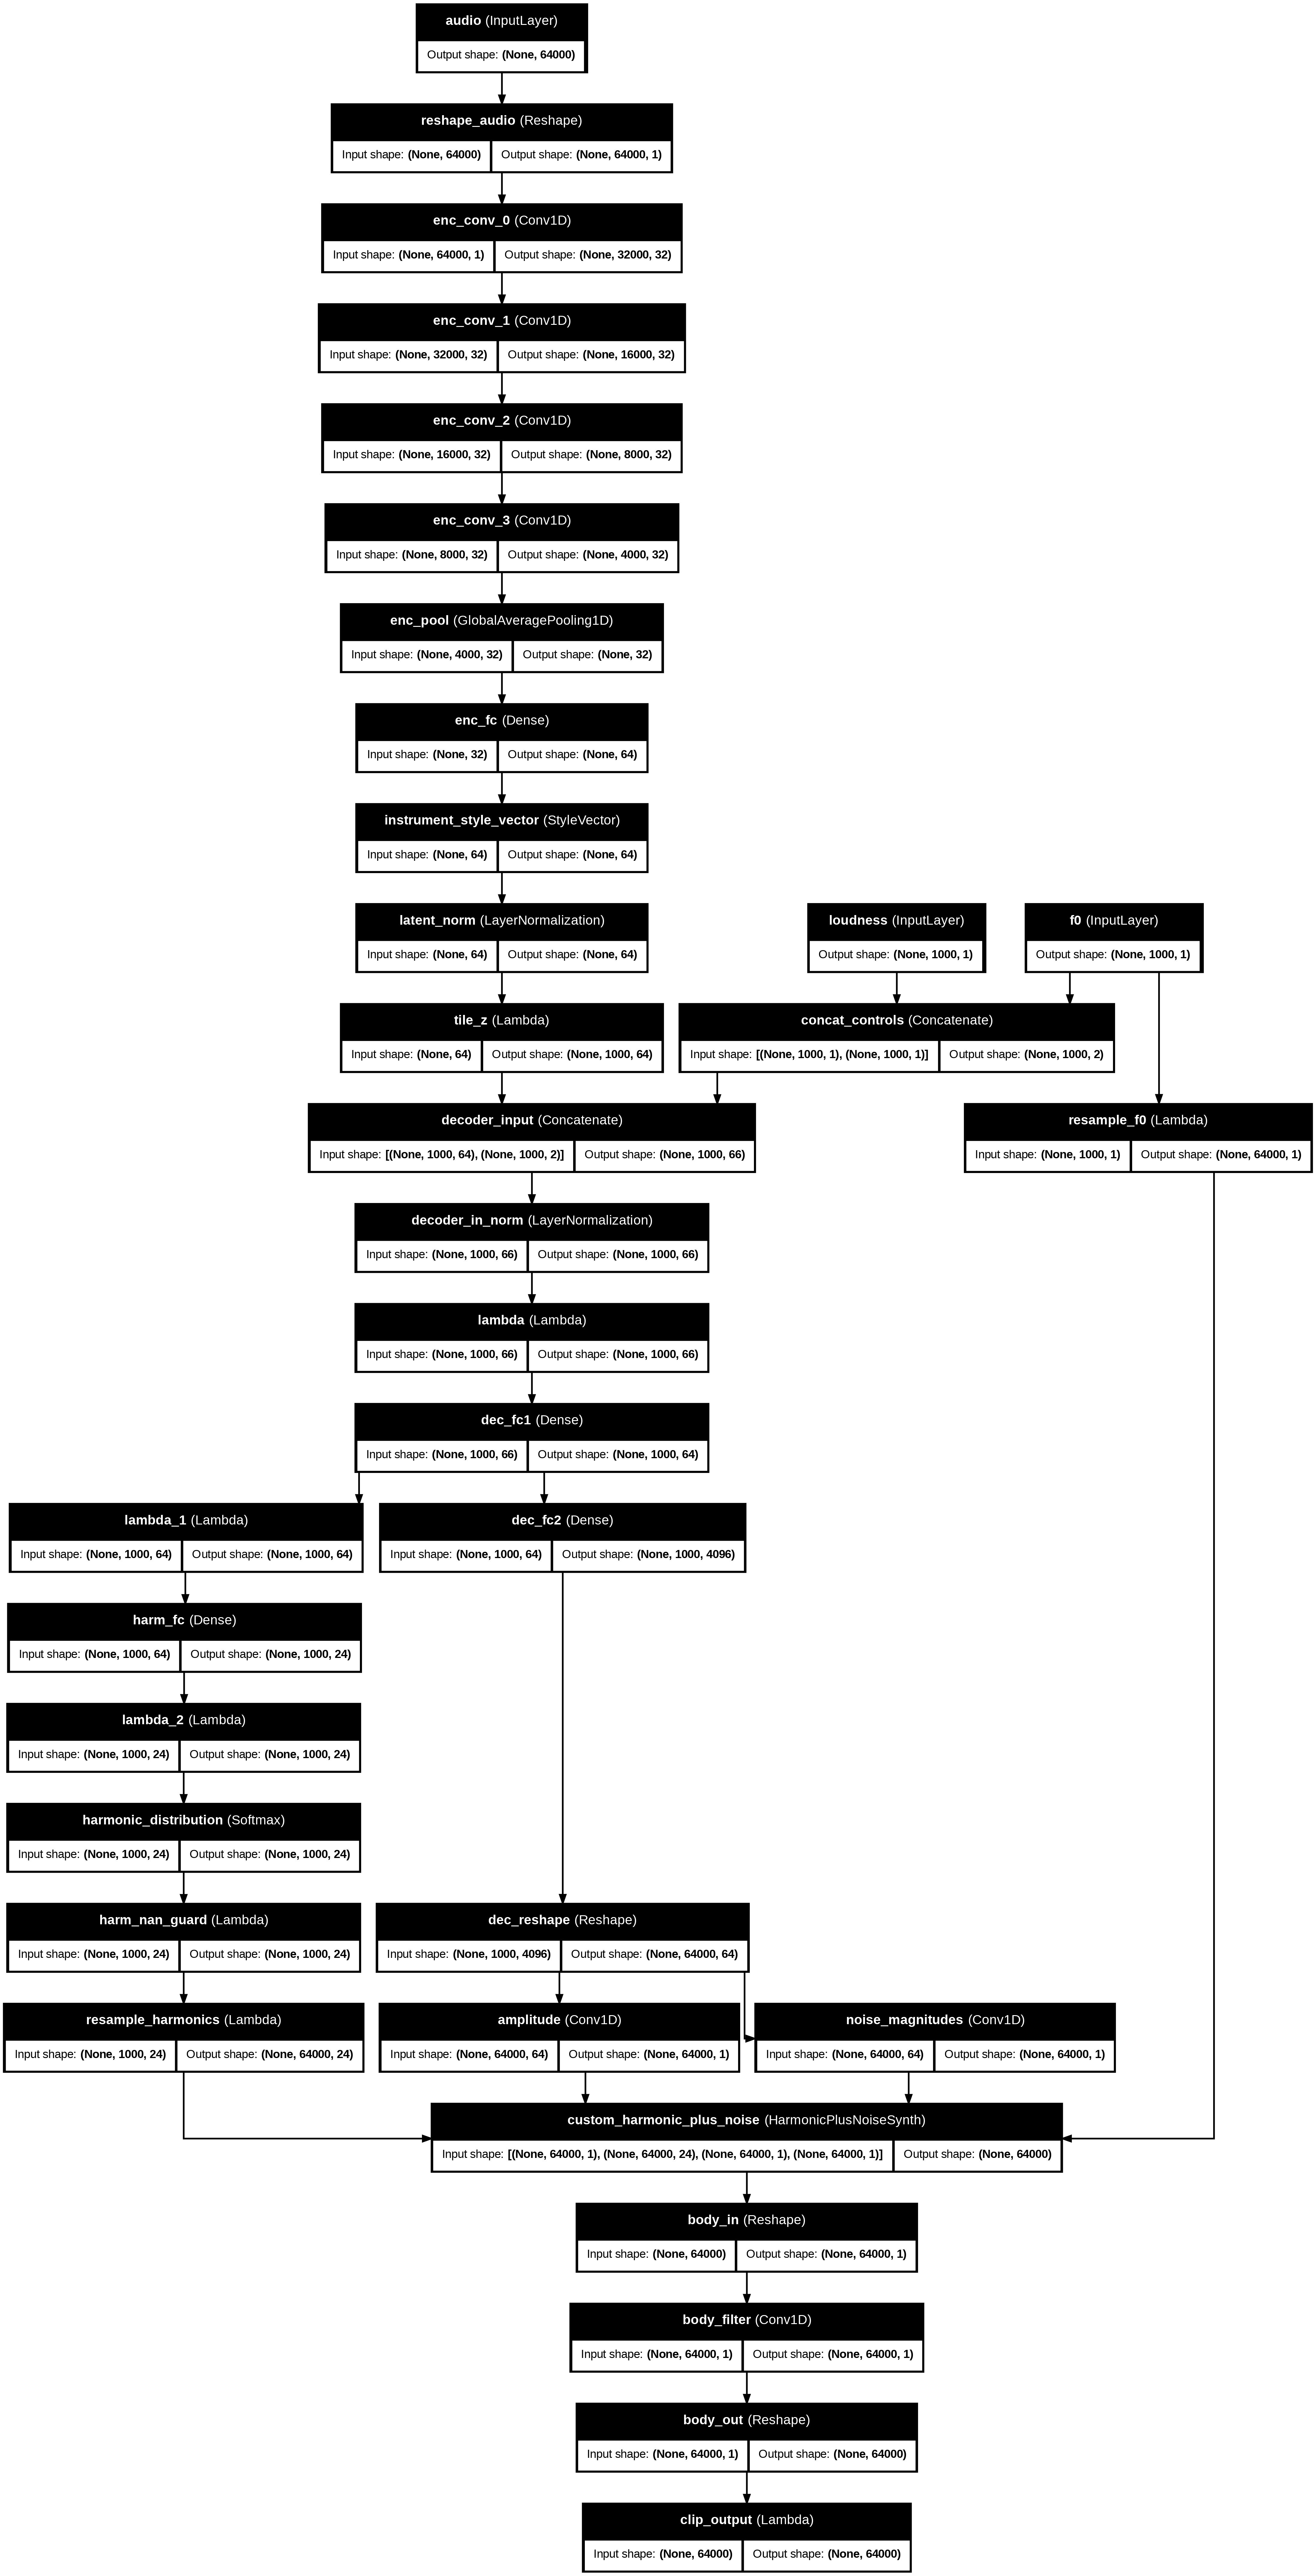

In [ ]:
plot_model(
    model,
    to_file='ddsp_autoencoder.png',
    show_shapes=True,       # annotate each arrow with tensor shapes
    show_layer_names=True,  # label each node with layer.name
    expand_nested=False     # don’t collapse nested models
)

# 3) Display it inline
Image(filename='ddsp_autoencoder.png')


# 4. Training the harmonics model


## 4.1 Defining loss functions
- Spectral convergence
- Harmonic distribution difference


In [ ]:
def spectral_convergence(y, y_hat):
    S  = tf.abs(tf.signal.stft(y,   1024, HOP))
    Ŝ = tf.abs(tf.signal.stft(y_hat,1024, HOP))
    num = tf.norm(Ŝ - S, ord='euclidean', axis=[-2,-1])
    den = tf.norm(S,      ord='euclidean', axis=[-2,-1])
    return tf.reduce_mean(num/den)


In [ ]:
def loss_audio(y_true, y_pred):
    eps = 1e-6

    def safe(x):
        x = tf.where(tf.math.is_finite(x), x, tf.zeros_like(x))
        return tf.clip_by_value(x, -1e3, 1e3)

    y_true = safe(y_true)
    y_pred = safe(y_pred)

    sc = spectral_convergence(y_true, y_pred)
    mag = SpectralLoss(
        fft_sizes=(512, 256),
        loss_type="L1",
        mag_weight=0.6,
        logmag_weight=1.8,
    )(y_true, y_pred)

    total = 3.0 * sc + mag
    total = safe(total)
    return total


def loss_harmonics(y_true_db, y_pred, eps=1e-8):
    # Clip predictions
    y_true_db = tf.clip_by_value(y_true_db, -60.0, 0.0)
    y_pred = tf.clip_by_value(y_pred, eps, 1.0)
    y_pred_db = 20.0 * tf.math.log(y_pred) / tf.math.log(10.0)
    y_pred_db = tf.clip_by_value(y_pred_db, -60.0, 0.0)

    # Absolute dB difference
    diff_db = tf.abs(y_true_db - y_pred_db)

    # Weight by harmonic index to emphasize lower harmonics
    n_harm = tf.shape(y_true_db)[-1]
    weights = tf.cast(tf.range(1, n_harm + 1), tf.float32)
    weights = 1.0 / (weights ** 1.2)   # or 1/h^1.0 for stronger decay

    diff_db = diff_db * weights

    return tf.reduce_mean(diff_db)

## 4.2 Decaying learning rate for more precise training

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,     # starting LR
    decay_steps=5 * NUM_WINDOWS // BATCH, # how often to decay
    decay_rate=0.9,                  # multiply LR by this each decay step
    staircase=True                   # stepwise or continuous
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

## 4.3 Tensorflow optimizations for faster processing

In [ ]:
tf.config.optimizer.set_jit(False)
print("XLA disabled for memory stability.")

tf.config.optimizer.set_experimental_options({'cudnn_autotune': False})

XLA disabled for memory stability.


## 4.4 Compiling the model and defining checkpoints
### 4.4.1
The model is compiled with respective weights for two losses and the optimizer created earlier.


In [ ]:
model.compile(
    optimizer=optimizer,
    loss={
        "recon": loss_audio,
        "harm_pred": loss_harmonics
    },
    loss_weights={
        "recon": 1.0,
        "harm_pred": 125.0
    }
)

### 4.4.2 Creating checkpoints
Checkpoints for only saving the best weights (**ckpt**), clearing the memory in between the epochs to not hoard the unnecessary graphs in memory (**ClearMemory**) and **(LossLogger)** for keeping track of the losses and the learning rate.

In [ ]:
ckpt = ModelCheckpoint(
    WEIGHTS_FILE,
    save_weights_only=True,
    save_freq='epoch',
    save_best_only=True,
    monitor='loss',
    verbose=1
)

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.experimental.async_clear_error()  # optional
        print(f"🧹 Epoch {epoch+1} done — cleanup triggered")

class LossLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            "total_loss": [],
            "recon_loss": [],
            "harm_loss": [],
            "lr": [],
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        self.history["total_loss"].append(logs.get("loss"))
        self.history["recon_loss"].append(logs.get("recon_loss", None))
        self.history["harm_loss"].append(logs.get("harm_pred_loss", None))

        lr = float(K.get_value(self.model.optimizer.learning_rate))
        self.history["lr"].append(lr)


## 4.5 Clearing the backend before training


In [ ]:
tf.keras.backend.clear_session()
gc.collect()

0

## 4.6 Training the model

In [ ]:
print("Starting training…")
loss_logger = LossLogger()
history = model.fit(
    ds,
    epochs=EPOCHS,
    steps_per_epoch=NUM_WINDOWS // BATCH,
    callbacks=[ckpt, ClearMemory(), loss_logger]
)
print("Training complete. Weights saved to", WEIGHTS_FILE)

Starting training…
Epoch 1/75


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['noise_magnitudes/kernel', 'noise_magnitudes/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - harm_pred_loss: 3.9504 - loss: 512.6280 - recon_loss: 18.8306
Epoch 1: loss improved from inf to 504.74512, saving model to /content/drive/MyDrive/DDSP_Project/models/Chainsaw.weights.h5
🧹 Epoch 1 done — cleanup triggered
5/5 ━━━━━━━━━━━━━━━━━━━━ 138s 245ms/step - harm_pred_loss: 3.9409 - loss: 511.3142 - recon_loss: 18.7039
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - harm_pred_loss: 3.8008 - loss: 492.1824 - recon_loss: 17.0821
Epoch 2: loss improved from 504.74512 to 497.39282, saving model to /content/drive/MyDrive/DDSP_Project/models/Chainsaw.weights.h5
🧹 Epoch 2 done — cleanup triggered
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - harm_pred_loss: 3.8065 - loss: 493.0508 - recon_loss: 17.2431
Epoch 3/75
4/5 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - harm_pred_loss: 3.8834 - loss: 502.7236 - recon_loss: 17.2969 
Epoch 3: loss did not improve from 497.39282
🧹 Epoch 3 done — cleanup triggered
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - harm_pred_loss: 3.882

## 4.7 Visualizing the training results
### 4.7.1 Learning curve for the overall loss

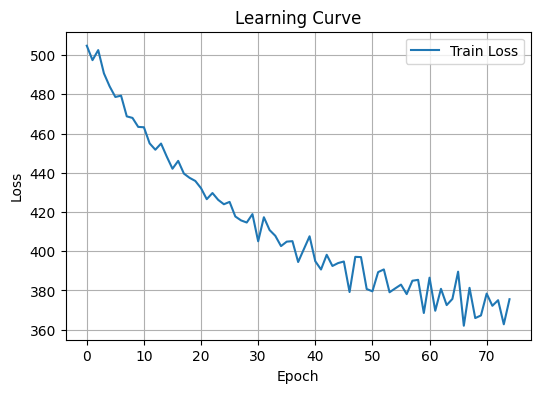

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(history.history['loss'],  label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 4.7.2 Harmonic, recon and total loss components

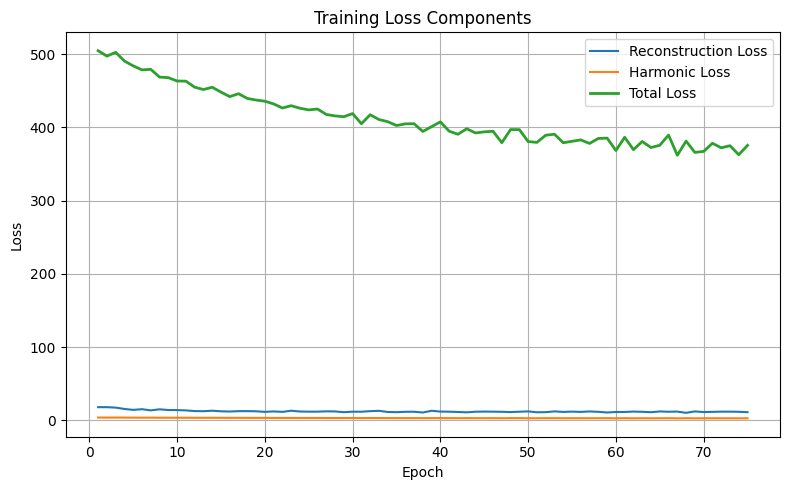

In [ ]:

epochs = range(1, len(loss_logger.history["total_loss"]) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss_logger.history["recon_loss"], label="Reconstruction Loss")
plt.plot(epochs, loss_logger.history["harm_loss"], label="Harmonic Loss")
plt.plot(epochs, loss_logger.history["total_loss"], label="Total Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.7.3 Learning rate decay

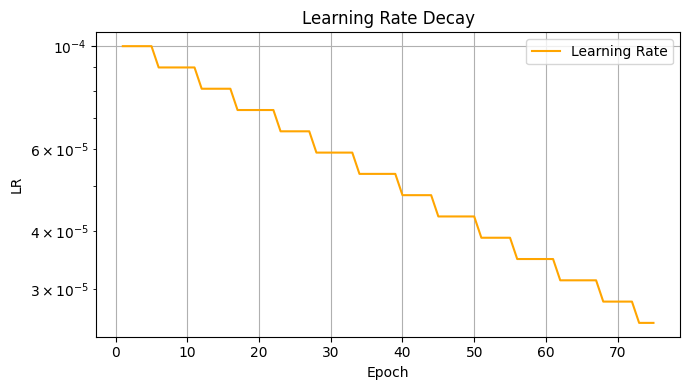

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epochs, loss_logger.history["lr"], color="orange", label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Decay")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 5. Training ADSR model
ADSR envelope in musical synthesis defines how each note's loudness behaves from it's beginning to the end.
- Attack - the time taken for the rise of the level from nil to peak.
- Decay - the time taken for the level to reduce from the attack level to the sustain level.
- Sustain - the level maintained until the key is released.
- Release - the time taken for the level to decay to nil.

This behaviour is pretty consistent for most instruments, especially plucked string instruments, such as piano, guitar or harp. The features are infered from the same dataset the harmonic models were trained on although an experiment with harmonic distribution of one instrument and the ADSR behaviour of another could be done.

---

*Example:*

*Guitar being played like a cello with softer attacks, crescendo and longer sustain.*

In [ ]:
adsr_logger = LossLogger()

adsr = ADSRModel(
    frames_win=FRAMES_WIN,
    sample_rate=SR,
    frame_rate=FRAME_RATE,
    batch_size=BATCH,
    model_dir=MODELS_DIR,
    name="ADSR_chainsaw.weights",
    loss_logger=adsr_logger
)

ds_adsr = adsr.make_dataset(audio_windows, f0_windows, loudness_windows)
adsr.train(ds_adsr, num_windows=NUM_WINDOWS, epochs=50)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3082
Epoch 1: loss improved from inf to 0.28271, saving model to /content/drive/MyDrive/DDSP_Project/models/ADSR_chainsaw.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 0.3040
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2593
Epoch 2: loss improved from 0.28271 to 0.24311, saving model to /content/drive/MyDrive/DDSP_Project/models/ADSR_chainsaw.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 0.2566
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2223
Epoch 3: loss improved from 0.24311 to 0.21534, saving model to /content/drive/MyDrive/DDSP_Project/models/ADSR_chainsaw.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.2212
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1734
Epoch 4: loss improved from 0.21534 to 0.18261, saving model to /content/drive/MyDrive/DDSP_Project/models/ADSR_chainsaw.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.1750
Epoch 5/50
5/5 ━━━━━

## 5.1 Training loss visualization

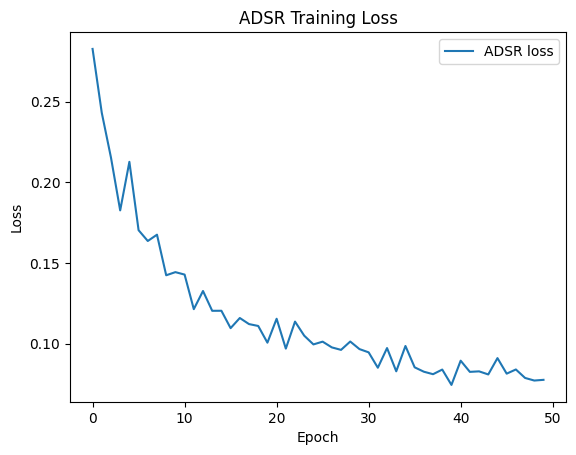

In [ ]:
plt.plot(adsr_logger.history["total_loss"], label="ADSR loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ADSR Training Loss")
plt.legend()
plt.show()


# 6. Generating Results
After training two models it becomes possible to turn a melody played on one instruments into the one played on a different instrument.
First the harmonics are predicted and later - ADSR envelope is applied


## 6.1 Harmonic prediction
Processing order:

Loading the input file -> extracting it's f0 frames -> visualizing the input -> building a dummy model and loading the pre-trained weights -> predicting the output in chunks -> saving and visualizing the output

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


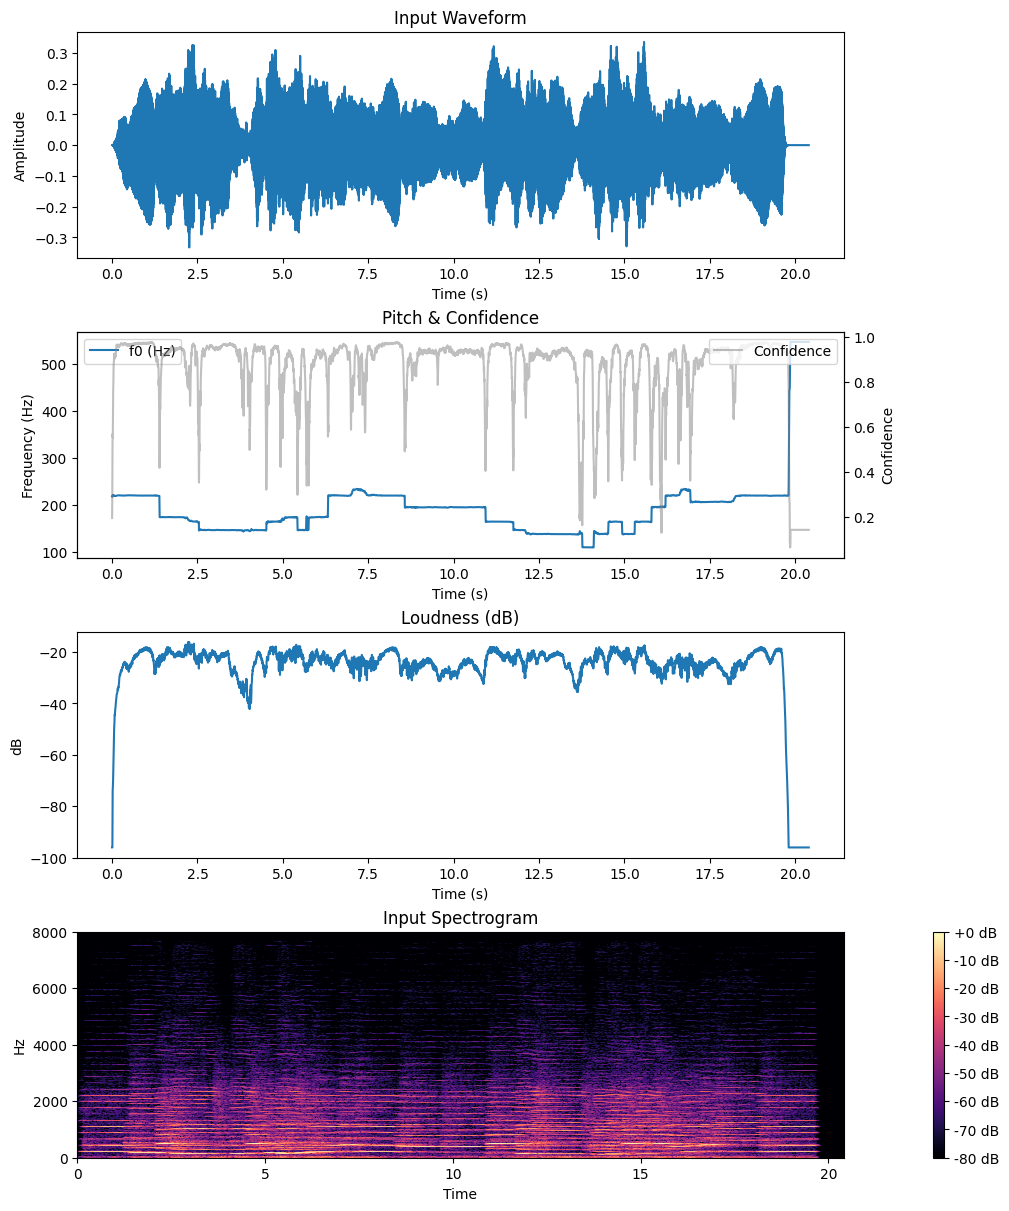

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
✅ Loaded weights from /content/drive/MyDrive/DDSP_Project/models/Sax.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


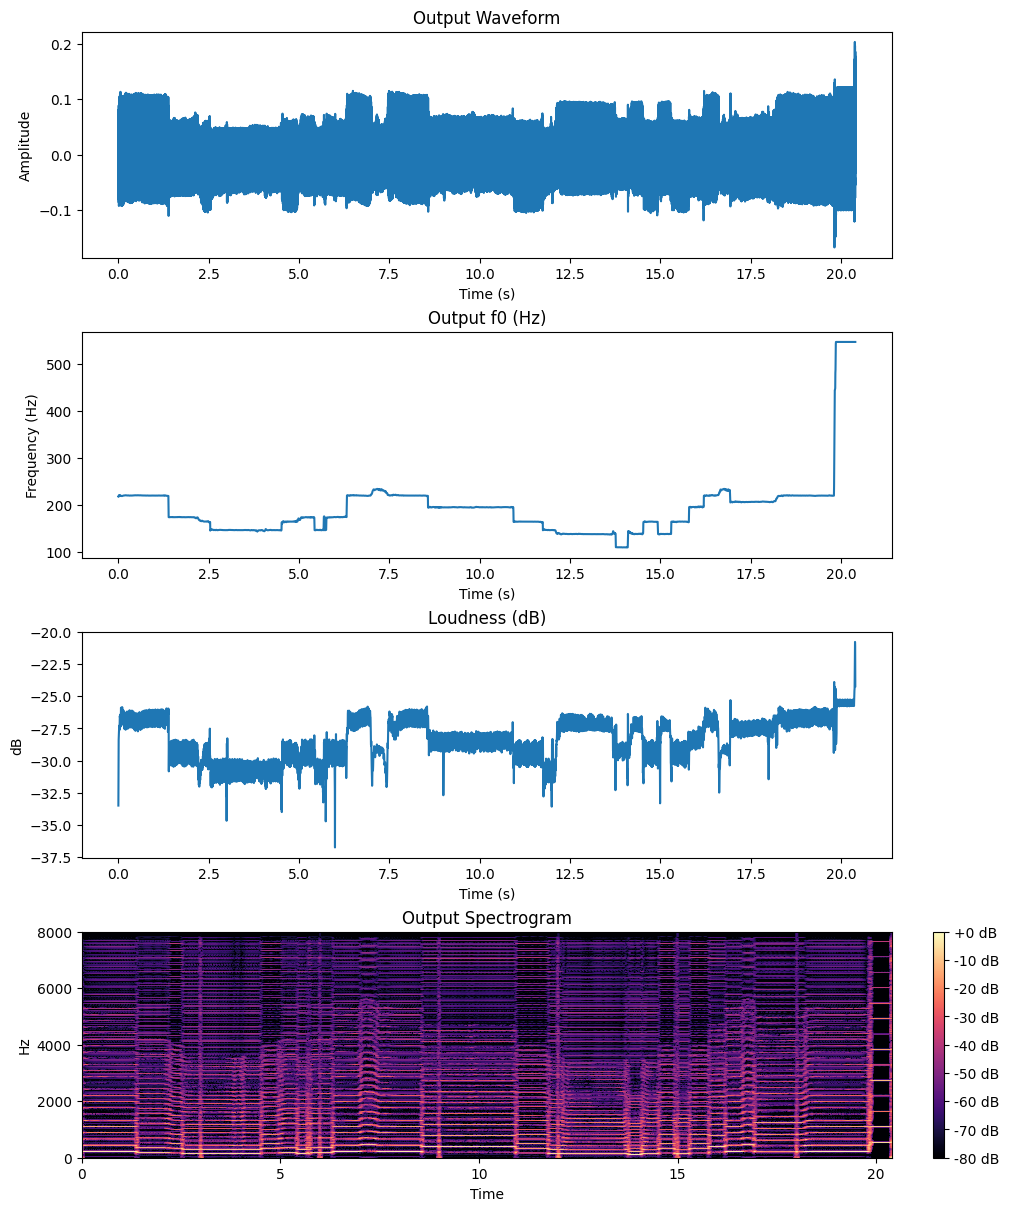

✅ Saved timbre‐transferred audio to out/oboe_to_sax.wav
🎵 Harmonic predictions shape: (5250, 24)


In [ ]:
# ─── Hyperparameters ────────────────────────────────────────────
SR          = 16000
FRAME_RATE  = 250
WINDOW_SEC  = 3
HOP         = SR // FRAME_RATE
SAMPLES_WIN = WINDOW_SEC * SR          # 64 000
FRAMES_WIN  = WINDOW_SEC * FRAME_RATE  # 1 000

# ─── Paths ──────────────────────────────────────────────────────
INPUT_WAV  = "Shostakovich.wav"
OUTPUT_WAV = "out/oboe_to_sax.wav"
WEIGHTS    = WEIGHTS_FILE

os.makedirs(os.path.dirname(OUTPUT_WAV), exist_ok=True)

# ─── 1) Extract features ─────────────────────────────────────────
proc = AudioProcessor(
    INPUT_WAV,
    sr=SR,
    frame_rate=FRAME_RATE,
    model_capacity='full'
)
data        = proc.extract_features()
audio_in    = data['audio']      # [N_samples]
f0_frames   = data['f0']         # [N_frames]
loud_frames = data['loudness']   # [N_frames]
hop_length  = data['hop_length'] # = SR/FRAME_RATE

# ─── 2) Visualize input diagnostics ──────────────────────────────
visualize.plot_input(
    audio      = audio_in,
    sr         = SR,
    f0         = f0_frames,
    confidence = data.get('confidence', None),
    loudness   = loud_frames,
    hop_length = hop_length,
    frame_rate = FRAME_RATE
)

# ─── 3) Build & dummy‐build the model ───────────────────────────
model = build_ddsp_autoencoder(
    sample_rate=SR,
    frame_rate=FRAME_RATE,
    window_sec=WINDOW_SEC,
    conv_channels=32,
    num_layers=4,
    kernel_size=3,
    latent_dim=64,
    decoder_hidden=64,
    n_harmonics=24,
    synth_window=257
)

# Run one zero‐input window so all weights are created
_ = model.predict([
    np.zeros((1, SAMPLES_WIN),   dtype=np.float32),
    np.zeros((1, FRAMES_WIN, 1), dtype=np.float32),
    np.zeros((1, FRAMES_WIN, 1), dtype=np.float32),
], batch_size=1)

# Load your trained weights
model.load_weights(WEIGHTS)
print("✅ Loaded weights from", WEIGHTS)

# ─── 4) Windowed inference ───────────────────────────────────────
n_samples = len(audio_in)
n_frames  = len(f0_frames)
n_win     = math.ceil(n_samples / SAMPLES_WIN)

audio_out_chunks = []
harmonics_out_chunks = []  # to store harmonic predictions too

for w in range(n_win):
    # sample indices
    s0 = w * SAMPLES_WIN
    s1 = s0 + SAMPLES_WIN
    # frame indices
    f0 = w * FRAMES_WIN
    f1 = f0 + FRAMES_WIN

    # Slice & pad if needed
    chunk_audio = audio_in[s0:s1]
    if len(chunk_audio) < SAMPLES_WIN:
        chunk_audio = np.pad(chunk_audio, (0, SAMPLES_WIN - len(chunk_audio)))

    chunk_f0 = f0_frames[f0:f1]
    if len(chunk_f0) < FRAMES_WIN:
        chunk_f0 = np.pad(chunk_f0, (0, FRAMES_WIN - len(chunk_f0)))

    chunk_loud = loud_frames[f0:f1]
    if len(chunk_loud) < FRAMES_WIN:
        chunk_loud = np.pad(chunk_loud, (0, FRAMES_WIN - len(chunk_loud)))

    # Batch‐ify
    a_in = chunk_audio[None, :]
    f_in = chunk_f0[None, :, None]
    l_in = chunk_loud[None, :, None]

    # Predict both outputs
    preds = model.predict([a_in, f_in, l_in], batch_size=1)
    y_audio = preds["recon"][0]       # [SAMPLES_WIN]
    y_harms = preds["harm_pred"][0]   # [FRAMES_WIN, n_harmonics]

    # Trim to original chunk length
    out_len = min(SAMPLES_WIN, n_samples - s0)
    audio_out_chunks.append(y_audio[:out_len])
    harmonics_out_chunks.append(y_harms[:FRAMES_WIN])

# Concatenate all windows back to full length
audio_out = np.concatenate(audio_out_chunks, axis=0)
harmonics_out = np.concatenate(harmonics_out_chunks, axis=0)  # [N_frames, n_harmonics]

audio_out = np.nan_to_num(audio_out, nan=0.0, posinf=1.0, neginf=-1.0)

# Optionally hard-limit amplitude range
audio_out = np.clip(audio_out, -1.0, 1.0)
# ─── 5) Visualize & save ────────────────────────────────────────
loud_out = proc.compute_loudness(audio_out)
visualize.plot_output(
    audio      = audio_out,
    sr         = SR,
    f0         = f0_frames,
    loudness   = loud_out,
    hop_length = hop_length,
    frame_rate = FRAME_RATE
)

sf.write(OUTPUT_WAV, audio_out, SR)
print("✅ Saved timbre‐transferred audio to", OUTPUT_WAV)
print("🎵 Harmonic predictions shape:", harmonics_out.shape)


## 6.2 Applying ADSR envelope

✅ Loaded ADSR weights from /content/drive/MyDrive/DDSP_Project/models/ADSR_model_v4_pluck.weights.h5
✅ ADSR weights loaded
🔧 Flattening DDSP audio for ADSR conditioning...
🔍 Extracting features from flattened audio...
 10/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


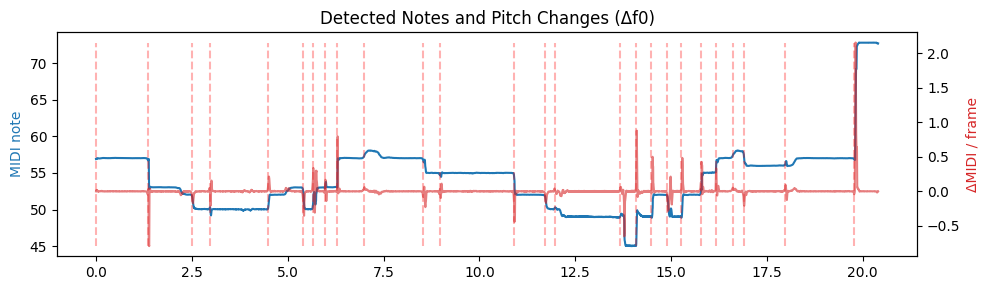

🎛️ Predicting ADSR envelope...


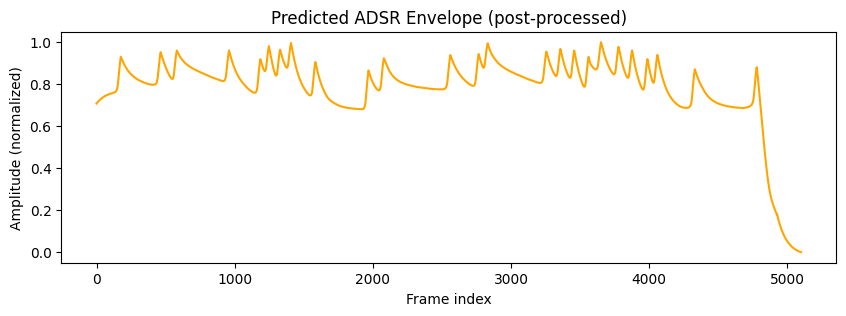

🎚️ Applying ADSR envelope...


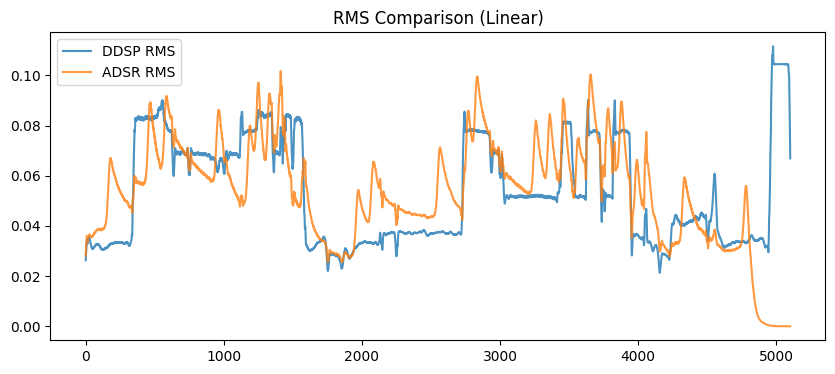

✅ Saved ADSR-shaped audio to out/oboe_to_guitar_adsr.wav


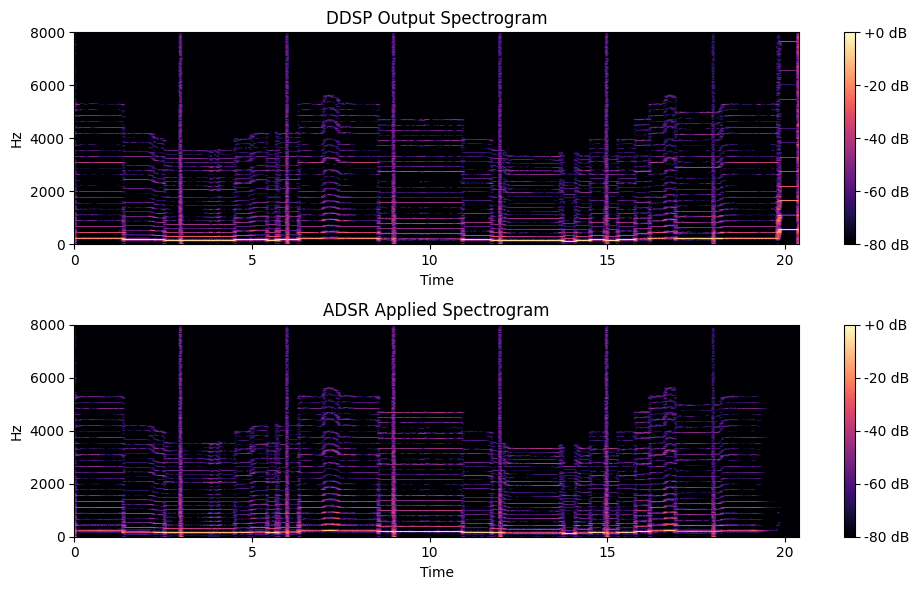

In [ ]:
# ─── Helper: Emphasize ADSR contrast ─────────────────────────────────────────
def emphasize_adsr(env, attack_boost=2.5, decay_shape=2.8):
    """Boost attacks and soften decays in a normalized envelope."""
    env = np.clip(env, 0.0, 1.0)
    env = env ** (1.0 / decay_shape)
    env = np.power(env, 1.0 / attack_boost)
    env = (env - np.min(env)) / (np.max(env) - np.min(env) + 1e-8)
    return env


# ─── 1) Load trained ADSR model ─────────────────────────────────────────────
adsr = ADSRModel(
    frames_win=FRAMES_WIN,  # must match training window size
    sample_rate=SR,
    frame_rate=FRAME_RATE,
    batch_size=4,
    model_dir=MODELS_DIR,
    name="ADSR_sax.weights"
)
adsr.load()
print("✅ ADSR weights loaded")

# ─── 2) Flatten DDSP output BEFORE feature extraction ────────────────────────
print("🔧 Flattening DDSP audio for ADSR conditioning...")
rms = librosa.feature.rms(
    y=audio_out,
    frame_length=1024,
    hop_length=SR // FRAME_RATE
)[0]
rms /= np.max(rms) + 1e-6
rms_interp = np.interp(np.linspace(0, len(rms), len(audio_out)),
                       np.arange(len(rms)), rms)

audio_flat = audio_out / (rms_interp + 0.15)  # flatten dynamic range
audio_flat = np.clip(audio_flat, -1.0, 1.0)

# ─── 3) Extract features from flattened audio ────────────────────────────────
print("🔍 Extracting features from flattened audio...")
tmp_wav = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
sf.write(tmp_wav.name, audio_flat, SR)

proc = AudioProcessor(
    tmp_wav.name,
    sr=SR,
    frame_rate=FRAME_RATE,
    model_capacity='full',
    num_harmonics=24
)
data_flat = proc.extract_features()

f0_frames = data_flat["f0"]
loud_frames = data_flat["loudness"]

# ─── 4) Derived conditioning features ────────────────────────────────────────
midi = 69 + 12 * np.log2(np.maximum(f0_frames, 1e-5) / 440.0)
df0 = np.concatenate([[0], np.diff(midi)])

# slightly more smoothing to suppress vibrato artifacts
df0_smooth = np.convolve(df0, np.ones(5) / 5, mode="same")

# Improved onset detection (Δf0 + loudness)
dloud = np.concatenate([[0], np.diff(loud_frames)])
dloud_smooth = np.convolve(dloud, np.ones(7)/7, mode="same")

# Normalize both cues
df0_norm = np.abs(df0_smooth) / (np.std(df0_smooth) + 1e-6)
dloud_norm = np.abs(dloud_smooth) / (np.std(dloud_smooth) + 1e-6)

# Combined onset activation (pitch + loudness)
onset_score = 0.7 * df0_norm + 0.3 * dloud_norm

# 🔧 LESS SENSITIVE onset threshold
thr = np.mean(onset_score) + 0.8 * np.std(onset_score)
onset = (onset_score > thr).astype(np.float32)

# Merge close detections (<0.15 s apart)
min_sep = int(0.15 * FRAME_RATE)
for i in range(1, len(onset)):
    if onset[i] and np.any(onset[max(0, i-min_sep):i]):
        onset[i] = 0

# Synthetic loudness (decoupled from DDSP’s amplitude)
loud_synth = np.clip(0.3 + 0.7 * np.convolve(onset, np.ones(20), mode="same"), 0, 1)
loud_norm = (loud_synth - np.mean(loud_synth)) / (np.std(loud_synth) + 1e-6)

# ─── Debug: visualize detected notes ─────────────────────────────────────────
t_frames = np.arange(len(midi)) / FRAME_RATE
fig, ax1 = plt.subplots(figsize=(10, 3))
ax1.plot(t_frames, midi, color="tab:blue", label="MIDI pitch (f0)")
ax1.set_ylabel("MIDI note", color="tab:blue")
ax2 = ax1.twinx()
ax2.plot(t_frames, df0_smooth, color="tab:red", alpha=0.6, label="Δf0 (smoothed)")
ax2.set_ylabel("ΔMIDI / frame", color="tab:red")
onset_idx = np.where(onset > 0)[0]
ax1.vlines(onset_idx / FRAME_RATE, np.min(midi), np.max(midi),
            color="red", alpha=0.3, linestyle="--", label="onsets")
plt.title("Detected Notes and Pitch Changes (Δf0)")
fig.tight_layout()
plt.show()


# ─── 5) Predict ADSR envelope in windows ─────────────────────────────────────
print("🎛️ Predicting ADSR envelope...")
FRAME_LEN = FRAMES_WIN
adsr_env_chunks = []

for start in range(0, len(f0_frames), FRAME_LEN):
    end = start + FRAME_LEN
    f0_chunk    = f0_frames[start:end]
    df0_chunk   = df0_smooth[start:end]
    onset_chunk = onset[start:end]
    loud_chunk  = loud_norm[start:end]

    if len(f0_chunk) < FRAME_LEN:
        pad = FRAME_LEN - len(f0_chunk)
        f0_chunk    = np.pad(f0_chunk, (0, pad))
        df0_chunk   = np.pad(df0_chunk, (0, pad))
        onset_chunk = np.pad(onset_chunk, (0, pad))
        loud_chunk  = np.pad(loud_chunk, (0, pad))

    env_chunk = adsr.model.predict({
        "f0": f0_chunk[None, :, None],
        "df0": df0_chunk[None, :, None],
        "onset": onset_chunk[None, :, None],
        "loudness": loud_chunk[None, :, None],
    }, verbose=0)[0, :, 0]

    adsr_env_chunks.append(env_chunk[:len(f0_chunk)])

adsr_env = np.concatenate(adsr_env_chunks, axis=0)[:len(f0_frames)]

# ─── 6) Post-process ADSR envelope ───────────────────────────────────────────
adsr_env = emphasize_adsr(adsr_env, attack_boost=2.4, decay_shape=1.6)
attack_mask = np.convolve(onset, np.ones(5), mode="same")
adsr_env *= (1 + 0.5 * np.clip(attack_mask, 0, 1))

# Smooth with exponential decay for longer tails
adsr_env = np.clip(adsr_env, 0, 1)
adsr_env = adsr_env ** 0.6
decay_kernel = np.exp(-np.linspace(0, 5, 350))
decay_kernel /= np.sum(decay_kernel)
adsr_env = np.convolve(adsr_env, decay_kernel, mode="same")
adsr_env = (adsr_env - np.min(adsr_env)) / (np.max(adsr_env) - np.min(adsr_env) + 1e-6)

plt.figure(figsize=(10, 3))
plt.plot(adsr_env, color="orange")
plt.title("Predicted ADSR Envelope (post-processed)")
plt.xlabel("Frame index")
plt.ylabel("Amplitude (normalized)")
plt.show()


# ─── 7) Upsample & apply ADSR to audio ───────────────────────────────────────
print("🎚️ Applying ADSR envelope...")
n_frames_env = len(adsr_env)
n_audio = len(audio_flat)
hop_len = SR // FRAME_RATE
env_times = np.linspace(0, n_frames_env * hop_len, n_frames_env)
audio_times = np.arange(n_audio)
adsr_env_up = np.interp(audio_times, env_times, adsr_env)
adsr_env_up = (adsr_env_up - np.min(adsr_env_up)) / (np.max(adsr_env_up) - np.min(adsr_env_up) + 1e-6)
adsr_env_up = adsr_env_up ** 2.7

audio_adsr = np.clip(audio_flat * adsr_env_up, -1.0, 1.0)

target_rms = np.sqrt(np.mean(audio_out**2))
curr_rms = np.sqrt(np.mean(audio_adsr**2)) + 1e-6
audio_adsr *= target_rms / curr_rms
audio_adsr = np.clip(audio_adsr, -1.0, 1.0)

# ─── 8) Compare RMS & loudness ───────────────────────────────────────────────
rms_out  = librosa.feature.rms(y=audio_out,  frame_length=1024, hop_length=SR//FRAME_RATE)[0]
rms_adsr = librosa.feature.rms(y=audio_adsr, frame_length=1024, hop_length=SR//FRAME_RATE)[0]

plt.figure(figsize=(10, 4))
plt.plot(rms_out,  label="DDSP RMS", alpha=0.8)
plt.plot(rms_adsr, label="ADSR RMS", alpha=0.8)
plt.legend()
plt.title("RMS Comparison (Linear)")
plt.show()

# ─── 9) Save and visualize spectrograms ──────────────────────────────────────
OUTPUT_WAV_ADSR = OUTPUT_WAV.replace(".wav", "_adsr.wav")
sf.write(OUTPUT_WAV_ADSR, audio_adsr, SR)
print(f"✅ Saved ADSR-shaped audio to {OUTPUT_WAV_ADSR}")

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
visualize.plot_spectrogram(plt.gca(), audio_out, SR, hop_length, title="DDSP Output Spectrogram")
plt.subplot(2, 1, 2)
visualize.plot_spectrogram(plt.gca(), audio_adsr, SR, hop_length, title="ADSR Applied Spectrogram")
plt.tight_layout()
plt.show()


## 6.3 Visualizing predicted note changes

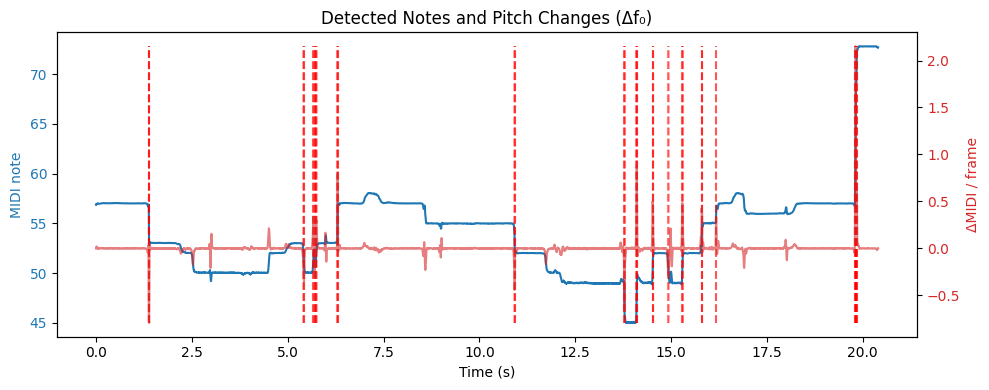

In [ ]:
# ─── Debug: visualize detected notes and pitch transitions ────────────────────
t_frames = np.arange(len(midi)) / FRAME_RATE  # time in seconds

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(t_frames, midi, color="tab:blue", label="MIDI pitch (f0)")
ax1.set_ylabel("MIDI note", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second y-axis for df0 (Δpitch per frame)
ax2 = ax1.twinx()
ax2.plot(t_frames, df0_smooth, color="tab:red", alpha=0.6, label="Δf₀ (smoothed)")
ax2.set_ylabel("ΔMIDI / frame", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Onset markers (where Δf₀ crosses threshold)
onset_indices = np.where(np.abs(df0_smooth) > 0.25)[0]
ax1.vlines(onset_indices / FRAME_RATE, ymin=np.min(midi), ymax=np.max(midi),
            color="red", alpha=0.3, linestyle="--", label="onset")

ax1.set_xlabel("Time (s)")
ax1.set_title("Detected Notes and Pitch Changes (Δf₀)")
fig.tight_layout()
plt.show()


## 6.4 Comparing the pre- and after ADSR loudness envelopes and spectrograms

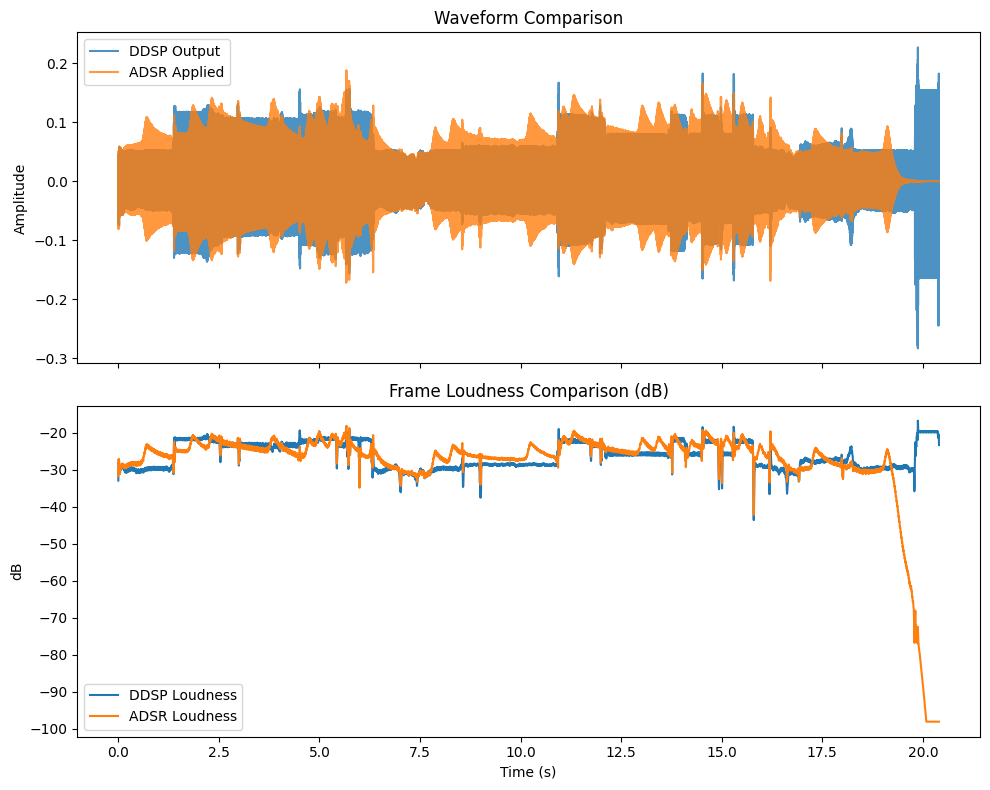

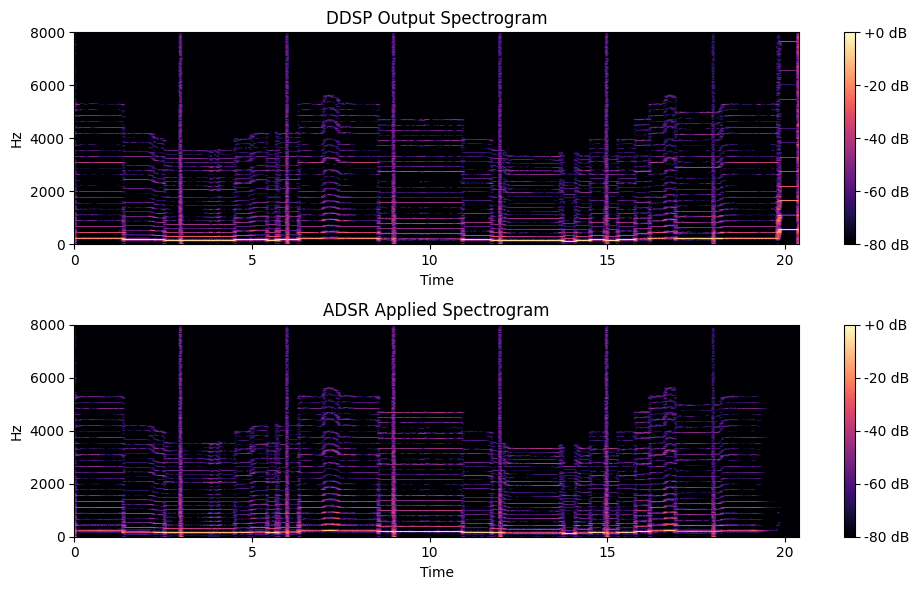

In [ ]:
# ─── 7) Compute loudness for comparison ─────────────────────────────────
loud_adsr = proc.compute_loudness(audio_adsr)
loud_out  = proc.compute_loudness(audio_out)

# ─── 8) Plot waveform + loudness comparison ─────────────────────────────
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(np.arange(len(audio_out)) / SR, audio_out, label="DDSP Output", alpha=0.8)
axs[0].plot(np.arange(len(audio_adsr)) / SR, audio_adsr, label="ADSR Applied", alpha=0.8)
axs[0].set_title("Waveform Comparison")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

axs[1].plot(np.arange(len(loud_out)) / FRAME_RATE, loud_out, label="DDSP Loudness")
axs[1].plot(np.arange(len(loud_adsr)) / FRAME_RATE, loud_adsr, label="ADSR Loudness")
axs[1].set_title("Frame Loudness Comparison (dB)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("dB")
axs[1].legend()

plt.tight_layout()
plt.show()

# ─── 9) Spectrogram comparison ──────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
visualize.plot_spectrogram(plt.gca(), audio_out, SR, hop_length, title="DDSP Output Spectrogram")
plt.subplot(2, 1, 2)
visualize.plot_spectrogram(plt.gca(), audio_adsr, SR, hop_length, title="ADSR Applied Spectrogram")
plt.tight_layout()
plt.show()


In [ ]:
def plot_adsr_with_note_changes(audio, sr, f0, loudness, adsr_env=None, frame_rate=250, title="ADSR Note Change Debug"):
    """
    Plots waveform and note-change markers from Δf0.
    Optionally overlays predicted ADSR envelope.
    """
    # Compute Δf0 (Hz difference)
    df0 = np.concatenate([[0], np.diff(f0)])
    # Detect note changes as strong Δf0 spikes (normalized)
    df0_norm = np.abs(df0) / (np.max(np.abs(df0)) + 1e-6)
    change_mask = df0_norm > 0.1  # threshold, tweak if needed

    # Get time axes
    t_audio = np.arange(len(audio)) / sr
    t_frames = np.arange(len(f0)) / frame_rate

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t_audio, audio / np.max(np.abs(audio)), label="Waveform", alpha=0.6)
    plt.plot(t_frames, df0_norm * 0.9, color="gray", alpha=0.5, label="Δf0 (normalized)")

    # Add note-change markers
    for t in t_frames[change_mask]:
        plt.axvline(t, color="red", alpha=0.3, linestyle="--")

    # Optionally add ADSR envelope
    if adsr_env is not None:
        adsr_up = librosa.resample(adsr_env, orig_sr=frame_rate, target_sr=sr)
        plt.plot(t_audio[:len(adsr_up)], adsr_up / np.max(adsr_up), color="orange", label="ADSR Envelope")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return change_mask


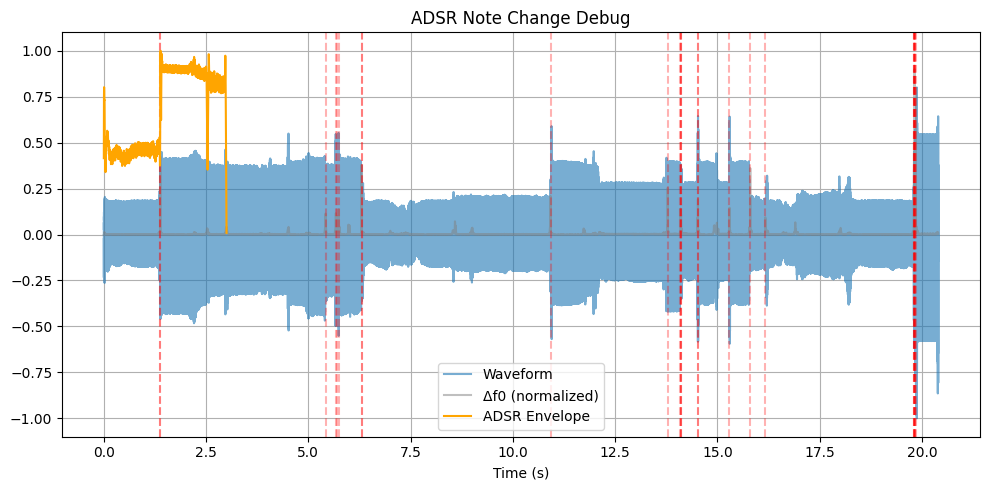

In [ ]:
adsr_env = adsr.predict(f0_frames, loud_frames)
mask = plot_adsr_with_note_changes(audio_out, SR, f0_frames, loud_frames, adsr_env, FRAME_RATE)


# 7. Validation

In [ ]:
# ─── Harmonic Head Diagnostics ─────────────────────────────────────────────

# 1️⃣ Access harmonic head
try:
    hd_layer = model.get_layer("harmonic_distribution")
except Exception as e:
    raise RuntimeError("Model doesn't have a 'harmonic_distribution' layer.") from e

hd_head = tf.keras.Model(model.inputs, hd_layer.output)

# 2️⃣ Select an E4-like frame
E4 = 320.0
if 'voiced_mask' not in locals() or voiced_mask is None:
    voiced_mask = np.ones_like(f0_frames, dtype=bool)

idx = np.where((np.abs(f0_frames - E4) <= 3.0))[0]
if len(idx) == 0:
    idx = np.where((np.abs(f0_frames - E4) <= 5.0))[0]
if len(idx) == 0:
    idx = [int(np.argmin(np.abs(f0_frames - E4)))]

t_global = int(idx[0])
win_idx  = t_global // FRAMES_WIN
t_local  = t_global - win_idx * FRAMES_WIN

# 3️⃣ Slice window data (pad last if needed)
s0, s1 = win_idx * SAMPLES_WIN, (win_idx + 1) * SAMPLES_WIN
f0_, f1_ = win_idx * FRAMES_WIN, (win_idx + 1) * FRAMES_WIN

chunk_audio = audio[s0:s1]
chunk_f0    = f0_frames[f0_:f1_]
chunk_loud  = loudness[f0_:f1_]

if len(chunk_audio) < SAMPLES_WIN:
    chunk_audio = np.pad(chunk_audio, (0, SAMPLES_WIN - len(chunk_audio)))
if len(chunk_f0) < FRAMES_WIN:
    chunk_f0 = np.pad(chunk_f0, (0, FRAMES_WIN - len(chunk_f0)))
if len(chunk_loud) < FRAMES_WIN:
    chunk_loud = np.pad(chunk_loud, (0, FRAMES_WIN - len(chunk_loud)))

a_in = chunk_audio[None, :].astype(np.float32)
f_in = chunk_f0[None, :, None].astype(np.float32)
l_in = chunk_loud[None, :, None].astype(np.float32)

# 4️⃣ Predict harmonic distribution safely
pred_hd_full = hd_head.predict([a_in, f_in, l_in], verbose=0)
t_local = min(t_local, pred_hd_full.shape[1] - 1)
pred_hd = pred_hd_full[0, t_local]

# Sanitize for NaNs / Infs and normalize
eps = 1e-8
pred_hd = np.nan_to_num(pred_hd, nan=0.0, posinf=0.0, neginf=0.0)
pred_hd = np.maximum(pred_hd, eps)
pred_hd /= np.sum(pred_hd) + eps

# Convert to relative dB vs H1
h1 = max(pred_hd[0], eps)
pred_rel_db = 20.0 * np.log10((pred_hd + eps) / h1)
pred_rel_db = np.clip(pred_rel_db, -60.0, 0.0)

# 5️⃣ Target harmonics
target_rel_db = harm_rel_db[t_global] if 'harm_rel_db' in locals() and harm_rel_db is not None else None
if target_rel_db is not None and target_rel_db.shape[-1] != pred_rel_db.shape[-1]:
    Hmin = min(target_rel_db.shape[-1], pred_rel_db.shape[-1])
    target_rel_db = target_rel_db[:Hmin]
    pred_rel_db   = pred_rel_db[:Hmin]
    H = Hmin
else:
    H = pred_rel_db.shape[-1]

# 6️⃣ Plot
k = np.arange(1, H + 1)
plt.figure(figsize=(10, 4))
w = 0.4
if target_rel_db is not None:
    plt.bar(k - w / 2, target_rel_db, width=w, label="Target (rel dB)")
plt.bar(k + w / 2, pred_rel_db, width=w, label="Predicted (rel dB)")
plt.xlim(0.5, min(20, H) + 0.5)
plt.xlabel("Harmonic index k")
plt.ylabel("Relative level (dB vs H1)")
plt.title(f"E4 comparison @ global frame {t_global} (f0≈{f0_frames[t_global]:.2f} Hz)")
plt.legend()
out_path = "e4_harmonics_pred_vs_target_db.png"
plt.tight_layout()
plt.savefig(out_path, dpi=140)
plt.close()
print("Saved plot:", out_path)

# 7️⃣ Print compact numeric summary
def tolist(x): return [float(v) for v in list(x)]
summary = {
    "frame_index": t_global,
    "window_index": win_idx,
    "local_frame": t_local,
    "f0_at_frame_hz": float(f0_frames[t_global]),
    "H": int(H),
    "target_db_first10": tolist(target_rel_db[:24]) if target_rel_db is not None else None,
    "pred_db_first10": tolist(pred_rel_db[:24]),
    "plot_path": out_path,
}
print(json.dumps(summary, indent=2))


Saved plot: e4_harmonics_pred_vs_target_db.png
{
  "frame_index": 4953,
  "window_index": 6,
  "local_frame": 453,
  "f0_at_frame_hz": 305.0382080078125,
  "H": 24,
  "target_db_first10": [
    0.0,
    -8.023890495300293,
    -11.417616844177246,
    -21.568553924560547,
    -27.779659271240234,
    -20.686059951782227,
    -24.34620475769043,
    -32.5586051940918,
    -34.313941955566406,
    -46.2989387512207,
    -54.696998596191406,
    -70.0,
    -67.0354232788086,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0,
    -70.0
  ],
  "pred_db_first10": [
    0.0,
    -19.08443832397461,
    -28.80497169494629,
    -38.63051986694336,
    -44.51941680908203,
    -48.60377502441406,
    -53.928714752197266,
    -54.49728012084961,
    -57.53558349609375,
    -60.0,
    -60.0,
    -59.4337158203125,
    -60.0,
    -50.700233459472656,
    -60.0,
    -60.0,
    -60.0,
    -60.0,
    -58.24687194824219,
    -54.86467742919922,


In [ ]:
# --- Parameters ---
SR = 16000
DURATION_SEC = 3.0
FRAME_RATE = 250
N_SAMPLES = int(SR * DURATION_SEC)
FRAMES = int(DURATION_SEC * FRAME_RATE)
H = harm_rel_db.shape[-1]

# Choose the target frame
t_global = 224
f0_hz = np.full((1, FRAMES, 1), 315.0, dtype=np.float32)
amplitudes = np.ones((1, FRAMES, 1), np.float32) * 0.3
noise_magnitudes = np.zeros_like(amplitudes)

# Convert target dB to linear normalized
harm_target = harm_rel_db[t_global:t_global+1, :H].astype(np.float32)
harm_target_lin = 10 ** (harm_target / 20.0)
harm_target_lin /= np.sum(harm_target_lin, axis=-1, keepdims=True)

# Tile to full duration
harm_target_lin = np.tile(harm_target_lin[:, None, :], (1, FRAMES, 1))

# --- Synth ---
synth = HarmonicPlusNoiseSynth(
    n_samples=N_SAMPLES,
    sample_rate=SR,
    n_harmonics=H,
    window_size=257
)

audio = synth(amplitudes, harm_target_lin, noise_magnitudes, f0_hz)
audio_np = audio.numpy().squeeze()
sf.write("E4_target_synth.wav", audio_np, SR)
print("✅ Synthesized 3 s using target harmonic distribution → E4_target_synth.wav")


✅ Synthesized 3 s using target harmonic distribution → E4_target_synth.wav


In [ ]:
def validate_adsr_model(adsr_model, audio_window, f0_window, loud_window, sr, frame_rate, title="ADSR validation"):
    """
    Validate ADSRModel v4_pluck on a single window.
    Shows true RMS vs predicted envelope + onset markers.
    """
    frames_win = adsr_model.frames_win

    # --- 1️⃣ Prepare input features ---
    f0 = f0_window.astype(np.float32)
    loud = loud_window.astype(np.float32)

    # Pad or crop to model length
    def fix_len(x):
        if len(x) < frames_win:
            return np.pad(x, (0, frames_win - len(x)))
        return x[:frames_win]

    f0 = fix_len(f0)
    loud = fix_len(loud)

    # Compute extra features
    midi = 69 + 12 * np.log2(np.maximum(f0, 1e-6) / 440.0)
    df0 = np.concatenate([[0], np.diff(midi)]).astype(np.float32)
    onset = (np.abs(df0) > 0.25).astype(np.float32)

    loud_norm = (loud - np.min(loud)) / (np.max(loud) - np.min(loud) + 1e-6)
    dloud = np.concatenate([[0], np.diff(loud_norm)]).astype(np.float32)

    # Reshape inputs for model
    f0_in    = f0[None, :, None]
    loud_in  = loud_norm[None, :, None]
    df0_in   = df0[None, :, None]
    on_in    = onset[None, :, None]
    dloud_in = dloud[None, :, None]

    # --- 2️⃣ Model prediction ---
    pred_env = adsr_model.model.predict(
      [f0_in, df0_in, on_in, loud_in], verbose=0
      )[0, :, 0]


    # --- 3️⃣ True RMS envelope ---
    true_env = librosa.feature.rms(
        y=audio_window,
        frame_length=1024,
        hop_length=sr // frame_rate
    )[0]
    true_env = true_env / (np.max(true_env) + 1e-6)
    true_env = fix_len(true_env)

    # --- 4️⃣ Metrics ---
    mse = np.mean((true_env - pred_env) ** 2)
    corr = np.corrcoef(true_env, pred_env)[0, 1]

    print(f"Validation metrics → MSE: {mse:.6f} | Corr: {corr:.3f}")

    # --- 5️⃣ Plot ---
    t = np.arange(frames_win) / frame_rate
    plt.figure(figsize=(10, 5))
    plt.plot(t, true_env, label="True RMS envelope", color="gray")
    plt.plot(t, pred_env, label="Predicted ADSR envelope", color="orange")

    # Onset markers
    onset_times = t[onset > 0.25]
    for tt in onset_times:
        plt.axvline(tt, color="red", linestyle="--", alpha=0.3)

    plt.title(f"{title}\nMSE={mse:.5f}, Corr={corr:.3f}")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return mse, corr

import IPython.display as ipd

def play_validation_window(audio_window, sr, title="Audio window"):
    """Plays the audio snippet for the current validation window."""
    print(f"🎵 {title} — duration: {len(audio_window)/sr:.2f}s")
    return ipd.Audio(audio_window, rate=sr)



In [ ]:
# Pick random window
import numpy as np

i = np.random.randint(0, NUM_WINDOWS)

audio_sample = list(audio_windows.skip(i).take(1).as_numpy_iterator())[0]
f0_sample    = list(f0_windows.skip(i).take(1).as_numpy_iterator())[0]
loud_sample  = list(loudness_windows.skip(i).take(1).as_numpy_iterator())[0]

# Listen to the raw audio window
player = play_validation_window(audio_sample, SR, title=f"Validation window #{i}")
display(player)

# Run visual + numeric validation
validate_adsr_model(
    adsr,
    audio_sample,
    f0_sample,
    loud_sample,
    SR,
    FRAME_RATE,
    title=f"ADSR Validation window #{i}"
)


# 8. Copying the results to drive

In [ ]:
# !cp /content/*.wav /content/drive/MyDrive/DDSP_Project/
# !cp /content/*.py  /content/drive/MyDrive/DDSP_Project/
# !cp /content/*.npz  /content/drive/MyDrive/DDSP_Project/models
# !cp /content/models/*  /content/drive/MyDrive/DDSP_Project/models
# !cp /content/out/*  /content/drive/MyDrive/DDSP_Project/out
